In [1]:
# Cell 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier # RandomForest not used for AE
from sklearn.svm import OneClassSVM # Not used for AE
from sklearn.cluster import DBSCAN # Not used for AE
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization # Added BatchNormalization for Cell 9 model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2 # Added l2 for Cell 9 model
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Ensure eager execution is enabled.
# This should be one of the first TF operations.
try:
    if not tf.executing_eagerly(): # Check if not already eager
        tf.config.run_functions_eagerly(True)
    print(f"Eager execution for TensorFlow functions is: {tf.executing_eagerly()}")
except Exception as e:
    print(f"Could not set/verify eager execution: {e}")


print("All libraries imported successfully!")

Eager execution for TensorFlow functions is: True
All libraries imported successfully!


In [2]:
# Cell 2: Load and Initial Data Exploration
# Load the datasets
try:
    file_df = pd.read_csv('dataset/file.csv')
    users_df = pd.read_csv('dataset/users.csv')
    
    print("Dataset loaded successfully!")
    print(f"File dataset shape: {file_df.shape}")
    print(f"Users dataset shape: {users_df.shape}")
    
    print("\nFile dataset columns:")
    print(file_df.columns.tolist())
    
    print("\nUsers dataset columns:")
    print(users_df.columns.tolist())
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure 'file.csv' and 'users.csv' are in the current directory")

Dataset loaded successfully!
File dataset shape: (110036, 6)
Users dataset shape: (4000, 4)

File dataset columns:
['date', 'user', 'pc', 'activity', 'to_removable_media', 'from_removable_media']

Users dataset columns:
['employee_name', 'user_id', 'email', 'role']


In [3]:
# Cell 3: Data Preprocessing and Trimming
# Trim file dataset to 600,000 rows
print(f"Original file dataset size: {len(file_df)} rows")

# Sample 600,000 rows randomly to maintain data distribution
if len(file_df) > 600000:
    file_df = file_df.sample(n=600000, random_state=42).reset_index(drop=True)
    print(f"Dataset trimmed to: {len(file_df)} rows")
else:
    print(f"Dataset has {len(file_df)} rows (less than 600,000)")

# Display basic info about the trimmed dataset
print("\nFile dataset info after trimming:")
print(file_df.info())

print("\nFirst few rows of file dataset:")
print(file_df.head())

print("\nUsers dataset info:")
print(users_df.info())

Original file dataset size: 110036 rows
Dataset has 110036 rows (less than 600,000)

File dataset info after trimming:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110036 entries, 0 to 110035
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   date                  110036 non-null  object
 1   user                  110036 non-null  object
 2   pc                    110036 non-null  object
 3   activity              110036 non-null  object
 4   to_removable_media    110036 non-null  bool  
 5   from_removable_media  110036 non-null  bool  
dtypes: bool(2), object(4)
memory usage: 3.6+ MB
None

First few rows of file dataset:
                  date     user       pc   activity  to_removable_media  \
0  2011-05-01 06:53:50  ABM3203  PC-8311  File Open               False   
1  2011-05-01 07:15:27  CGW0692  PC-6774  File Open               False   
2  2011-05-01 07:15:27  CGW0692  PC-6774  File Open

In [4]:
# Cell 4: Data Cleaning and Feature Engineering
# Check for missing values
print("Missing values in file dataset:")
print(file_df.isnull().sum())

print("\nMissing values in users dataset:")
print(users_df.isnull().sum())

# Handle missing values if any
file_df = file_df.dropna()
users_df = users_df.dropna()

# Merge file data with user data for enhanced analysis
print("\nMerging datasets...")
merged_df = pd.merge(file_df, users_df, left_on='user', right_on='user_id', how='left')
print(f"Merged dataset shape: {merged_df.shape}")

# Create additional features for anomaly detection
print("\nCreating additional features...")

# Time-based features
if 'date' in merged_df.columns:
    merged_df['date'] = pd.to_datetime(merged_df['date'])
    merged_df['hour'] = merged_df['date'].dt.hour
    merged_df['day_of_week'] = merged_df['date'].dt.dayofweek
    merged_df['is_weekend'] = merged_df['day_of_week'].isin([5, 6]).astype(int)

# PC usage frequency per user
pc_user_counts = merged_df.groupby(['user', 'pc']).size().reset_index(name='pc_usage_count')
merged_df = pd.merge(merged_df, pc_user_counts, on=['user', 'pc'], how='left')

# Activity frequency per user
activity_user_counts = merged_df.groupby(['user', 'activity']).size().reset_index(name='activity_count')
merged_df = pd.merge(merged_df, activity_user_counts, on=['user', 'activity'], how='left')

# User activity diversity (number of different activities per user)
user_activity_diversity = merged_df.groupby('user')['activity'].nunique().reset_index()
user_activity_diversity.columns = ['user', 'activity_diversity']
merged_df = pd.merge(merged_df, user_activity_diversity, on='user', how='left')

print("Feature engineering completed!")

Missing values in file dataset:
date                    0
user                    0
pc                      0
activity                0
to_removable_media      0
from_removable_media    0
dtype: int64

Missing values in users dataset:
employee_name    0
user_id          0
email            0
role             0
dtype: int64

Merging datasets...
Merged dataset shape: (110036, 10)

Creating additional features...
Feature engineering completed!


In [5]:
# Cell 5: Drop Unnecessary Columns and Final Preprocessing
# Drop id and content columns as requested
columns_to_drop = []
if 'id' in merged_df.columns:
    columns_to_drop.append('id')
if 'content' in merged_df.columns:
    columns_to_drop.append('content')

print(f"Dropping columns: {columns_to_drop}")
if columns_to_drop:
    merged_df = merged_df.drop(columns=columns_to_drop)

print(f"Final dataset shape: {merged_df.shape}")
print(f"Final columns: {merged_df.columns.tolist()}")

Dropping columns: []
Final dataset shape: (110036, 16)
Final columns: ['date', 'user', 'pc', 'activity', 'to_removable_media', 'from_removable_media', 'employee_name', 'user_id', 'email', 'role', 'hour', 'day_of_week', 'is_weekend', 'pc_usage_count', 'activity_count', 'activity_diversity']


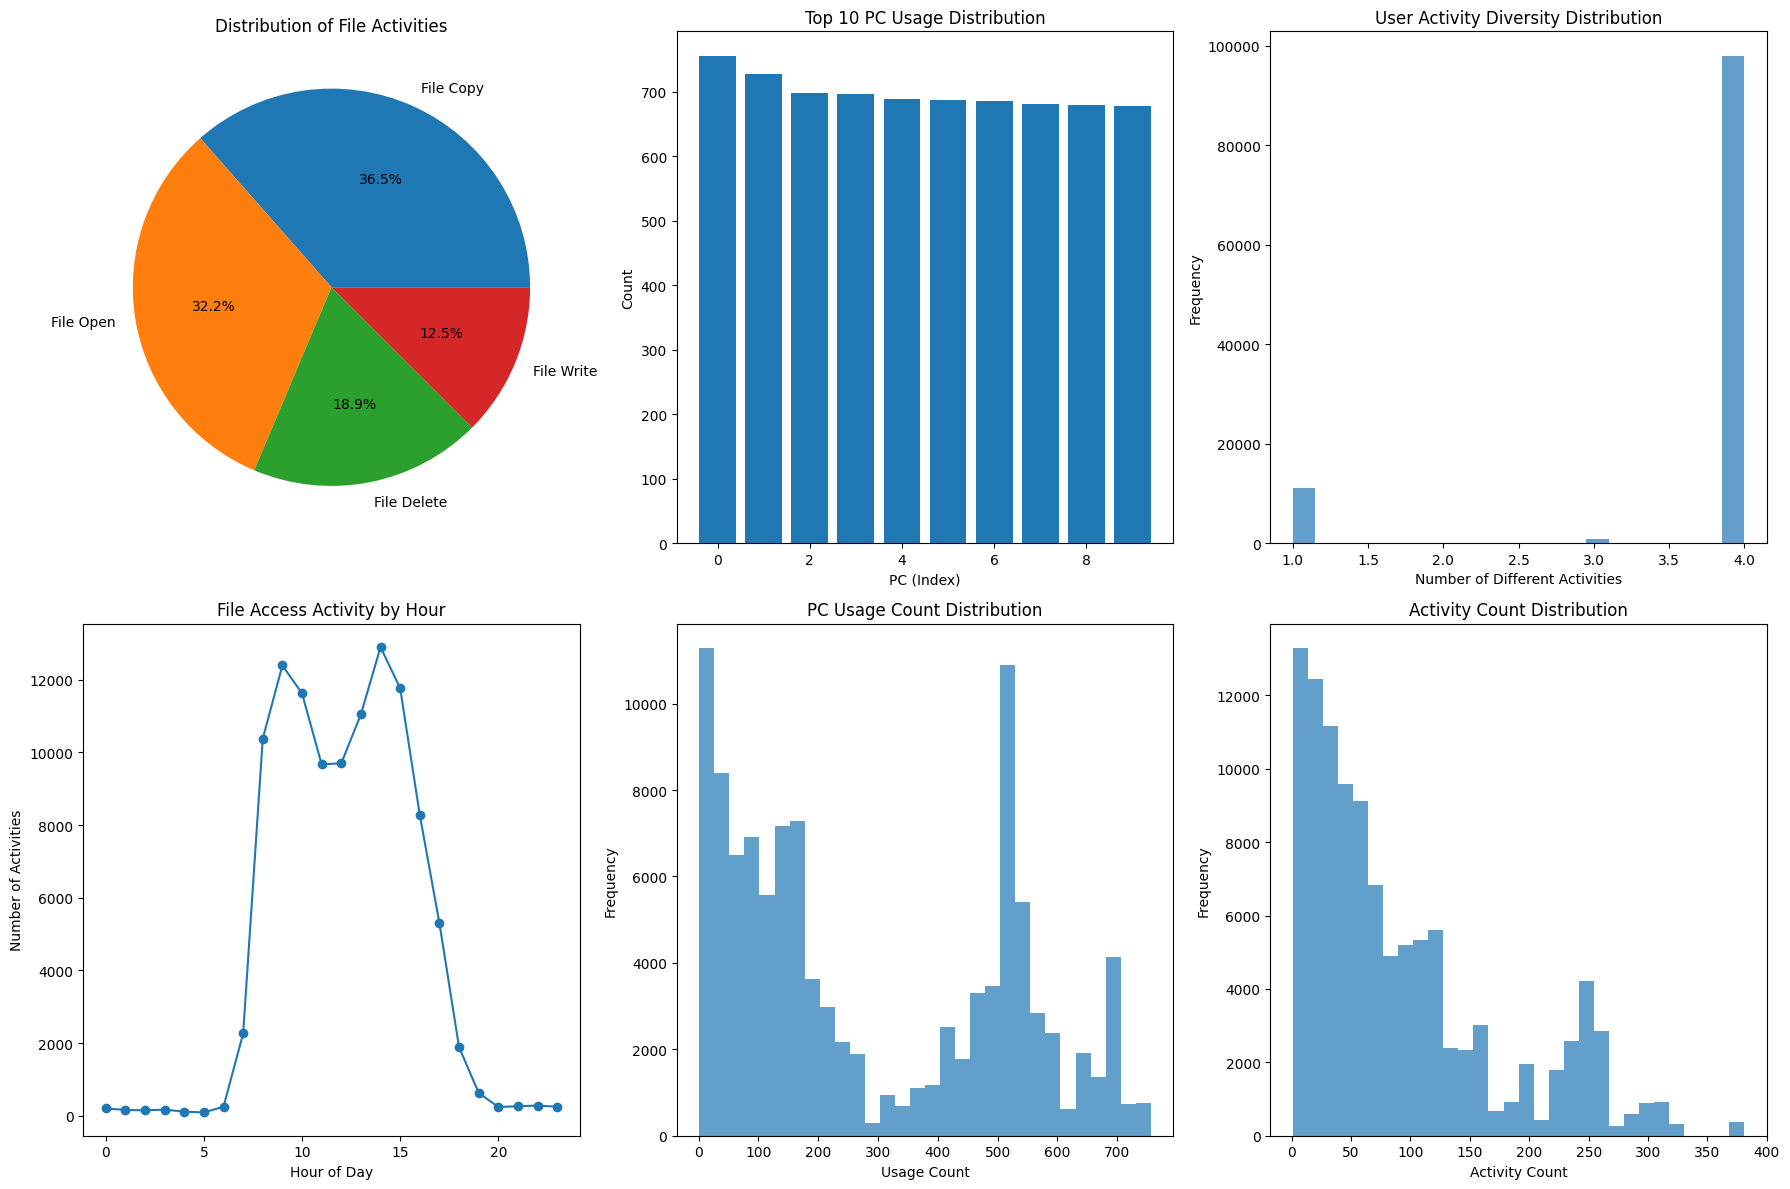

Exploratory Data Analysis completed!


In [6]:
# Cell 6: Exploratory Data Analysis and Visualization
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribution of activities
activity_counts = merged_df['activity'].value_counts()
axes[0, 0].pie(activity_counts.values, labels=activity_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Distribution of File Activities')

# PC usage distribution
pc_counts = merged_df['pc'].value_counts().head(10)
axes[0, 1].bar(range(len(pc_counts)), pc_counts.values)
axes[0, 1].set_title('Top 10 PC Usage Distribution')
axes[0, 1].set_xlabel('PC (Index)')
axes[0, 1].set_ylabel('Count')

# User activity diversity
axes[0, 2].hist(merged_df['activity_diversity'], bins=20, alpha=0.7)
axes[0, 2].set_title('User Activity Diversity Distribution')
axes[0, 2].set_xlabel('Number of Different Activities')
axes[0, 2].set_ylabel('Frequency')

# Time-based analysis (if date column exists)
if 'hour' in merged_df.columns:
    hourly_activity = merged_df['hour'].value_counts().sort_index()
    axes[1, 0].plot(hourly_activity.index, hourly_activity.values, marker='o')
    axes[1, 0].set_title('File Access Activity by Hour')
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Number of Activities')

# PC usage count distribution
axes[1, 1].hist(merged_df['pc_usage_count'], bins=30, alpha=0.7)
axes[1, 1].set_title('PC Usage Count Distribution')
axes[1, 1].set_xlabel('Usage Count')
axes[1, 1].set_ylabel('Frequency')

# Activity count distribution
axes[1, 2].hist(merged_df['activity_count'], bins=30, alpha=0.7)
axes[1, 2].set_title('Activity Count Distribution')
axes[1, 2].set_xlabel('Activity Count')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Exploratory Data Analysis completed!")

In [7]:
# Cell 7: Prepare Data for Machine Learning
# Select features for anomaly detection
feature_columns = ['pc_usage_count', 'activity_count', 'activity_diversity']

# Add time-based features if available
if 'hour' in merged_df.columns:
    feature_columns.extend(['hour', 'day_of_week', 'is_weekend'])

# Encode categorical variables
label_encoders = {}
categorical_columns = ['pc', 'activity']

if 'role' in merged_df.columns:
    categorical_columns.append('role')
if 'department' in merged_df.columns:
    categorical_columns.append('department')

for col in categorical_columns:
    if col in merged_df.columns:
        le = LabelEncoder()
        merged_df[f'{col}_encoded'] = le.fit_transform(merged_df[col].astype(str))
        label_encoders[col] = le
        feature_columns.append(f'{col}_encoded')

# Prepare feature matrix
X = merged_df[feature_columns].copy()

# Handle any remaining missing values
X = X.fillna(X.mean())

print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {feature_columns}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data preparation for ML completed!")

Feature matrix shape: (110036, 9)
Features used: ['pc_usage_count', 'activity_count', 'activity_diversity', 'hour', 'day_of_week', 'is_weekend', 'pc_encoded', 'activity_encoded', 'role_encoded']
Data preparation for ML completed!


In [8]:
# Cell 8: Create Synthetic Anomalies for Evaluation
# Since we don't have labeled anomalies, we'll create some synthetic ones for evaluation
np.random.seed(42)

# Create a copy for anomaly injection
X_with_anomalies = X_scaled.copy()
y_true = np.zeros(len(X_scaled))  # 0 = normal, 1 = anomaly

# Inject synthetic anomalies (5% of the data)
n_anomalies = int(0.05 * len(X_scaled))
anomaly_indices = np.random.choice(len(X_scaled), n_anomalies, replace=False)

# Create extreme values for anomalies
for idx in anomaly_indices:
    # Randomly select features to modify
    features_to_modify = np.random.choice(X_scaled.shape[1], 
                                        size=np.random.randint(1, 4), 
                                        replace=False)
    for feature_idx in features_to_modify:
        # Make values extreme (either very high or very low)
        if np.random.random() > 0.5:
            X_with_anomalies[idx, feature_idx] = np.random.normal(3, 0.5)  # High anomaly
        else:
            X_with_anomalies[idx, feature_idx] = np.random.normal(-3, 0.5)  # Low anomaly

y_true[anomaly_indices] = 1

print(f"Created {n_anomalies} synthetic anomalies ({n_anomalies/len(X_scaled)*100:.1f}% of data)")
print(f"Normal samples: {np.sum(y_true == 0)}")
print(f"Anomaly samples: {np.sum(y_true == 1)}")

Created 5501 synthetic anomalies (5.0% of data)
Normal samples: 104535
Anomaly samples: 5501


In [9]:
# Cell 9 (id: 1a7936b262d36560 - Model Setup)
# (Was "Cell 1: Setup and Model Creation" in your notebook source for this block)

print("Building improved autoencoder...")

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU # Added LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np

# Ensure TensorFlow 2.x behavior and clear any existing models
# This is good practice if re-running cells frequently.
tf.keras.backend.clear_session()

# Improved autoencoder architecture
def create_improved_autoencoder(input_dim):
    # Input layer
    input_layer = Input(shape=(input_dim,), name='input_layer')
    
    # Encoder with batch normalization, regularization, and LeakyReLU
    encoded = Dense(128, kernel_regularizer=l2(0.001), name='encoder_dense_1')(input_layer)
    encoded = LeakyReLU(alpha=0.01, name='encoder_leakyrelu_1')(encoded) # Changed to LeakyReLU
    encoded = BatchNormalization(name='bn_encoder_1')(encoded)
    encoded = Dropout(0.2, name='dropout_encoder_1')(encoded)
    
    encoded = Dense(64, kernel_regularizer=l2(0.001), name='encoder_dense_2')(encoded)
    encoded = LeakyReLU(alpha=0.01, name='encoder_leakyrelu_2')(encoded) # Changed to LeakyReLU
    encoded = BatchNormalization(name='bn_encoder_2')(encoded)
    encoded = Dropout(0.2, name='dropout_encoder_2')(encoded)
    
    # Bottleneck layer (latent representation)
    bottleneck = Dense(32, kernel_regularizer=l2(0.001), name='bottleneck_dense')(encoded)
    bottleneck = LeakyReLU(alpha=0.01, name='bottleneck_leakyrelu')(bottleneck) # Changed to LeakyReLU
    
    # Decoder (symmetric to encoder)
    decoded = Dense(64, kernel_regularizer=l2(0.001), name='decoder_dense_1')(bottleneck)
    decoded = LeakyReLU(alpha=0.01, name='decoder_leakyrelu_1')(decoded) # Changed to LeakyReLU
    decoded = BatchNormalization(name='bn_decoder_1')(decoded)
    decoded = Dropout(0.2, name='dropout_decoder_1')(decoded)
    
    decoded = Dense(128, kernel_regularizer=l2(0.001), name='decoder_dense_2')(decoded)
    decoded = LeakyReLU(alpha=0.01, name='decoder_leakyrelu_2')(decoded) # Changed to LeakyReLU
    decoded = BatchNormalization(name='bn_decoder_2')(decoded)
    decoded = Dropout(0.2, name='dropout_decoder_2')(decoded)
    
    # Output layer (same dimension as input, linear activation for regression)
    output_layer = Dense(input_dim, activation='linear', name='output_reconstruction')(decoded)
    
    # Create the autoencoder model
    autoencoder_model = Model(inputs=input_layer, outputs=output_layer, name='improved_autoencoder')
    
    return autoencoder_model

# Ensure X_with_anomalies is defined (should be from Cell 8, id: 3feb3f75286e2fa4)
if 'X_with_anomalies' not in globals():
    raise NameError("X_with_anomalies is not defined. Please ensure Cell 8 (synthetic anomaly generation) has been run before this cell.")
if X_with_anomalies is None or (hasattr(X_with_anomalies, 'shape') and X_with_anomalies.shape[0] == 0):
    raise ValueError("X_with_anomalies is None or empty. Cannot determine input dimension.")

input_dim_ae = X_with_anomalies.shape[1] # Renamed for clarity
autoencoder = create_improved_autoencoder(input_dim_ae)

# Compile with robust optimizer settings
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), # Added epsilon
    loss='mse',      # Mean Squared Error is standard for autoencoders
    metrics=['mae']  # Mean Absolute Error can also be informative
)

print("Autoencoder architecture:")
autoencoder.summary()

# Setup robust callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored quantity.
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss
    factor=0.2,            # Factor by which the learning rate will be reduced. new_lr = lr * factor (was 0.5)
    patience=8,            # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-7,           # Lower bound on the learning rate. (was 1e-6)
    verbose=1
)

print("Model setup completed! 'autoencoder', 'early_stopping', and 'reduce_lr' are defined.")
print("Ensure Cell 1 (initial_id) has 'tf.config.run_functions_eagerly(True)' and the kernel was restarted.")
print("Ensure Cell 10 (5ad039fc9ddc14bc) trains the autoencoder on X_train_normal data.")

Building improved autoencoder...

Autoencoder architecture:


Model: "improved_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_1 (Dense)              │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_leakyrelu_1 (LeakyReLU)      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_encoder_1 (BatchNormalization)    │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_encoder_1 (Dropout)          │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_2 (Dense)              │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_leakyrelu_2 (LeakyReLU)      │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_encoder_2 (BatchNormalization)    │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_encoder_2 (Dropout)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_dense (Dense)             │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_leakyrelu (LeakyReLU)     │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense_1 (Dense)              │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_leakyrelu_1 (LeakyReLU)      │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_decoder_1 (BatchNormalization)    │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_decoder_1 (Dropout)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense_2 (Dense)              │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_leakyrelu_2 (LeakyReLU)      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_decoder_2 (BatchNormalization)    │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_decoder_2 (Dropout)          │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_reconstruction (Dense)        │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,745 (96.66 KB)

 Trainable params: 23,977 (93.66 KB)

 Non-trainable params: 768 (3.00 KB)

Model setup completed! 'autoencoder', 'early_stopping', and 'reduce_lr' are defined.
Ensure Cell 1 (initial_id) has 'tf.config.run_functions_eagerly(True)' and the kernel was restarted.
Ensure Cell 10 (5ad039fc9ddc14bc) trains the autoencoder on X_train_normal data.


In [ ]:
# Cell 10 (id: 5ad039fc9ddc14bc - Training and Evaluation for Autoencoder)
print("Starting autoencoder training and evaluation...")

# TensorFlow and sklearn imports should ideally be in Cell 1.
# Re-importing for modularity if cells are run out of order during testing.
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Eager execution should have been set globally in Cell 1.
# You can verify its status:
# print(f"Eager execution status at start of Cell 10: {tf.executing_eagerly()}")

# Ensure X_with_anomalies and y_true are available from Cell 8 (3feb3f75286e2fa4)
if 'X_with_anomalies' not in globals() or 'y_true' not in globals():
    raise NameError("X_with_anomalies or y_true not defined. Please ensure Cell 8 (synthetic anomaly generation) has been run.")

# Ensure autoencoder, early_stopping, reduce_lr are available from Cell 9 (1a7936b262d36560 - model setup)
if 'autoencoder' not in globals() or 'early_stopping' not in globals() or 'reduce_lr' not in globals():
    raise NameError("Autoencoder model or callbacks (early_stopping, reduce_lr) not defined. Please ensure Cell 9 (model setup) has been run.")

# Prepare normal data for training the autoencoder
# Autoencoders for anomaly detection are trained on normal data only.
X_normal_data = X_with_anomalies[y_true == 0]
X_normal_data = X_normal_data.astype('float32') # Ensure correct dtype

autoencoder_trained_flag = False # Flag to track training success
history = None # Initialize history object
reconstruction_errors = np.array([]) # Initialize to empty
final_threshold = np.inf # Initialize threshold
y_pred_autoencoder = np.zeros_like(y_true) # Initialize predictions

if X_normal_data.shape[0] < 10: # Check if there's enough normal data
    print("Not enough normal data to train the autoencoder. Skipping autoencoder training.")
else:
    autoencoder_trained_flag = True
    # Split normal data for training and validation of the autoencoder
    X_train_normal, X_val_normal = train_test_split(X_normal_data, test_size=0.2, random_state=42)

    print(f"Normal training set size for AE: {X_train_normal.shape[0]}")
    print(f"Normal validation set size for AE: {X_val_normal.shape[0]}")

    print("Training improved autoencoder on normal data...")
    try:
        history = autoencoder.fit(
            X_train_normal, X_train_normal,  # Target is the input itself for AEs
            epochs=100,                      # Max epochs
            batch_size=256,
            validation_data=(X_val_normal, X_val_normal),
            callbacks=[early_stopping, reduce_lr], # Using callbacks defined in Cell 9
            verbose=1,
            shuffle=True
        )
    except RuntimeError as e:
        print(f"TensorFlow RuntimeError during primary fit: {e}")
        print("This often relates to eager execution. Ensure tf.config.run_functions_eagerly(True) is run at the very start (Cell 1).")
        print("Trying again with callbacks=None as a diagnostic step...")
        try:
            history = autoencoder.fit(
                X_train_normal, X_train_normal,
                epochs=50, # Reduced epochs for quicker diagnostic
                batch_size=256,
                validation_data=(X_val_normal, X_val_normal),
                callbacks=None, # NO CALLBACKS for this diagnostic attempt
                verbose=1,
                shuffle=True
            )
            print("Training with callbacks=None succeeded.")
        except RuntimeError as e2:
            print(f"TensorFlow RuntimeError persisted even with callbacks=None: {e2}")
            autoencoder_trained_flag = False # Mark as not trained if fallback also fails
            print("Autoencoder training failed.")
    except Exception as ex:
        print(f"An unexpected error occurred during training: {ex}")
        autoencoder_trained_flag = False
        print("Autoencoder training failed due to an unexpected error.")


if autoencoder_trained_flag and history is not None:
    print("Calculating reconstruction errors on the full dataset...")
    X_with_anomalies_float32 = X_with_anomalies.astype('float32') # Ensure correct dtype for prediction
    X_pred = autoencoder.predict(X_with_anomalies_float32, batch_size=256, verbose=0)
    reconstruction_errors = np.mean(np.square(X_with_anomalies_float32 - X_pred), axis=1)

    print("Calculating improved threshold based on normal data reconstruction errors...")
    if X_train_normal.shape[0] > 0:
        X_train_normal_pred = autoencoder.predict(X_train_normal, batch_size=256, verbose=0)
        normal_train_reconstruction_errors = np.mean(np.square(X_train_normal - X_train_normal_pred), axis=1)

        # Method 1: Statistical threshold (e.g., 99th percentile of normal errors for high specificity)
        threshold_percentile_normal = np.percentile(normal_train_reconstruction_errors, 99)
        
        # Method 2: IQR-based threshold on normal errors
        Q1_normal = np.percentile(normal_train_reconstruction_errors, 25)
        Q3_normal = np.percentile(normal_train_reconstruction_errors, 75)
        IQR_normal = Q3_normal - Q1_normal
        threshold_iqr_normal = Q3_normal + 1.5 * IQR_normal # Common factor for outliers
        
        # Method 3: Mean + N*std on normal errors
        mean_error_normal = np.mean(normal_train_reconstruction_errors)
        std_error_normal = np.std(normal_train_reconstruction_errors)
        threshold_std_normal = mean_error_normal + 3 * std_error_normal # Using 3 standard deviations
        
        print(f"99th percentile threshold (normal errors): {threshold_percentile_normal:.6f}")
        print(f"IQR-based threshold (normal errors): {threshold_iqr_normal:.6f}")
        print(f"Mean + 3*std threshold (normal errors): {threshold_std_normal:.6f}")
        
        final_threshold = threshold_percentile_normal # Example: choosing percentile method
    else:
        print("Warning: X_train_normal is empty, falling back to percentile on all reconstruction errors.")
        final_threshold = np.percentile(reconstruction_errors, 95) if len(reconstruction_errors) > 0 else np.inf

    print(f"Final threshold selected for Autoencoder: {final_threshold:.6f}")

    # Generate predictions based on the chosen threshold
    y_pred_autoencoder = (reconstruction_errors > final_threshold).astype(int)

    print(f"Anomalies detected by Autoencoder: {np.sum(y_pred_autoencoder)} ({np.mean(y_pred_autoencoder)*100:.2f}% of total data)")

    # Plot training history
    plt.figure(figsize=(12, 5)) # Adjusted figure size

    plt.subplot(1, 2, 1)
    if history and 'loss' in history.history:
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history: # Check if val_loss exists
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Autoencoder Model Loss (Trained on Normal Data)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Training history not available or training failed.', ha='center', va='center')
        plt.title('Model Loss - Not Available')

    plt.subplot(1, 2, 2)
    if len(reconstruction_errors) > 0: # Check if errors were calculated
        # Separate reconstruction errors for actual normal and actual anomalous data for plotting
        errors_normal_actual = reconstruction_errors[y_true == 0]
        errors_anomaly_actual = reconstruction_errors[y_true == 1]
        
        plt.hist(errors_normal_actual, bins=50, alpha=0.7, label='Normal Data Errors (Actual)', density=True)
        if len(errors_anomaly_actual) > 0: # Only plot if there are actual anomalies
            plt.hist(errors_anomaly_actual, bins=50, alpha=0.7, label='Anomalous Data Errors (Actual)', density=True)
        plt.axvline(final_threshold, color='red', linestyle='--', label=f'Threshold: {final_threshold:.6f}')
        plt.title('Reconstruction Error Distribution')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Reconstruction errors not available.', ha='center', va='center')
        plt.title('Reconstruction Error Distribution - Not Available')
        
    plt.tight_layout()
    plt.show()

elif not autoencoder_trained_flag : # If training was skipped or failed initially
    print("Autoencoder training was skipped or failed, no evaluation plots for AE.")


print("Autoencoder training and initial evaluation cell completed!")
# This 'threshold' variable will be used by your Cell 11 (id: a9df58f6a0bca605)
threshold = final_threshold 

Starting autoencoder training and evaluation...
Normal training set size for AE: 83628
Normal validation set size for AE: 20907
Training improved autoencoder on normal data...
Epoch 1/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.8138 - mae: 0.5374 - val_loss: 0.3469 - val_mae: 0.2460 - learning_rate: 0.0010
Epoch 2/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.3777 - mae: 0.3046 - val_loss: 0.2231 - val_mae: 0.1513 - learning_rate: 0.0010
Epoch 3/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2770 - mae: 0.2590 - val_loss: 0.1732 - val_mae: 0.1582 - learning_rate: 0.0010
Epoch 4/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2092 - mae: 0.2385 - val_loss: 0.1393 - val_mae: 0.1682 - learning_rate: 0.0010
Epoch 5/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.1594 - mae: 0.2234 - val_loss: 0.1159 - val_mae: 0.1800 - learning_rate: 0.0010
Epoch 6/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1246 - mae: 0.2123 - val_loss: 0.09

In [ ]:
# Cell 11: Calculate Reconstruction Errors and Detect Anomalies
# Calculate reconstruction errors
X_pred = autoencoder.predict(X_with_anomalies)
reconstruction_errors = np.mean(np.square(X_with_anomalies - X_pred), axis=1)

# Determine threshold for anomaly detection
threshold_percentile = 95  # Top 5% as anomalies
threshold = np.percentile(reconstruction_errors, threshold_percentile)

# Predict anomalies using autoencoder
y_pred_autoencoder = (reconstruction_errors > threshold).astype(int)

print(f"Reconstruction error threshold: {threshold:.6f}")
print(f"Autoencoder detected {np.sum(y_pred_autoencoder)} anomalies")

In [ ]:
from sklearn.model_selection import ParameterGrid

print("Starting lightweight Isolation Forest tuning...")

# Mini parameter grid for quicker search
param_grid = {
    'n_estimators': [100, 200],
    'max_samples': [0.8, 'auto'],
    'contamination': [0.05],
    'max_features': [1.0],
    'bootstrap': [False]
}

best_score = -np.inf
best_params = None
best_model = None

# Simple grid search
for params in ParameterGrid(param_grid):
    model = IsolationForest(random_state=42, n_jobs=-1, **params)
    y_pred = model.fit_predict(X_with_anomalies)
    y_pred_binary = (y_pred == -1).astype(int)

    if np.sum(y_pred_binary) > 0:
        f1 = f1_score(y_true, y_pred_binary, zero_division=0)
        if f1 > best_score:
            best_score = f1
            best_params = params
            best_model = model

if best_model is None:
    raise RuntimeError("No model detected anomalies. Try adjusting contamination.")

print(f"Best parameters: {best_params}")

# Predict and threshold
anomaly_scores = best_model.decision_function(X_with_anomalies)
threshold = np.percentile(anomaly_scores, 5)
y_pred_final = (anomaly_scores < threshold).astype(int)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_true, y_pred_final, zero_division=0))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Isolation Forest - Confusion Matrix")
plt.show()

if len(np.unique(y_true)) > 1:
    print(f"ROC AUC Score: {roc_auc_score(y_true, -anomaly_scores):.4f}")

print("Isolation Forest tuning completed!")

In [ ]:
# Cell 13: Model Performance Evaluation
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate anomaly detection model performance"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Evaluate all models
results = []
results.append(evaluate_model(y_true, y_pred_autoencoder, "Autoencoder"))
results.append(evaluate_model(y_true, y_pred_final, "Isolation Forest"))

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison Summary:")
print(results_df.round(4))

In [ ]:
# Cell 14: Detailed Visualizations and Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Reconstruction Error Distribution
axes[0, 0].hist(reconstruction_errors, bins=50, alpha=0.7, label='All Data')
axes[0, 0].axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
axes[0, 0].set_title('Autoencoder Reconstruction Error Distribution')
axes[0, 0].set_xlabel('Reconstruction Error')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# 2. Model Performance Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0, 1].bar(x + i*width, results_df[metric], width, label=metric)

axes[0, 1].set_title('Model Performance Comparison')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x + width * 1.5)
axes[0, 1].set_xticklabels(results_df['Model'], rotation=45)
axes[0, 1].legend()

# 3. Confusion Matrix for Best Model (Autoencoder)
cm = confusion_matrix(y_true, y_pred_autoencoder)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2])
axes[0, 2].set_title('Autoencoder Confusion Matrix')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# 4. ROC Curves (using reconstruction errors as scores)
fpr_ae, tpr_ae, _ = roc_curve(y_true, reconstruction_errors)
auc_ae = roc_auc_score(y_true, reconstruction_errors)

try:
    iso_scores = best_model.decision_function(X_with_anomalies)
    fpr_iso, tpr_iso, _ = roc_curve(y_true, -iso_scores)  # Negative: lower scores = more anomalous
    auc_iso = roc_auc_score(y_true, -iso_scores)
    
    axes[1, 0].plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {auc_iso:.3f})')
except Exception as e:
    print(f"Failed to compute ROC for Isolation Forest: {e}")

axes[1, 0].plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {auc_ae:.3f})')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_title('ROC Curves')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend()

# 5. Precision-Recall Curve
precision_ae, recall_ae, _ = precision_recall_curve(y_true, reconstruction_errors)
axes[1, 1].plot(recall_ae, precision_ae, label='Autoencoder')
axes[1, 1].set_title('Precision-Recall Curve')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].legend()

# 6. Feature Importance (Isolation Forest or Autoencoder fallback)
if hasattr(best_model, 'feature_importances_') and best_model.feature_importances_ is not None:
    feature_importances = best_model.feature_importances_
    feature_names = [f'Feature_{i}' for i in range(len(feature_importances))]
    sorted_idx = np.argsort(feature_importances)[::-1][:10]
    axes[1, 2].barh(range(len(sorted_idx)), feature_importances[sorted_idx])
    axes[1, 2].set_yticks(range(len(sorted_idx)))
    axes[1, 2].set_yticklabels([feature_names[i] for i in sorted_idx])
    axes[1, 2].set_title('Top 10 Features by Isolation Forest Importance')
    axes[1, 2].set_xlabel('Feature Importance Score')
else:
    # Fallback to autoencoder feature error contribution
    feature_errors = np.mean(np.abs(X_with_anomalies - X_pred), axis=0)
    feature_names = [f'Feature_{i}' for i in range(len(feature_errors))]
    sorted_idx = np.argsort(feature_errors)[::-1][:10]
    axes[1, 2].barh(range(len(sorted_idx)), feature_errors[sorted_idx])
    axes[1, 2].set_yticks(range(len(sorted_idx)))
    axes[1, 2].set_yticklabels([feature_names[i] for i in sorted_idx])
    axes[1, 2].set_title('Top 10 Features by Reconstruction Error')
    axes[1, 2].set_xlabel('Average Absolute Error')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 15: Detailed Analysis and Suspicious Activity Detection
print("=== DETAILED ANOMALY ANALYSIS ===")

# Find the most suspicious activities detected by the autoencoder
anomaly_indices = np.where(y_pred_autoencoder == 1)[0]
suspicious_activities = merged_df.iloc[anomaly_indices].copy()

if len(suspicious_activities) > 0:
    print(f"\nDetected {len(suspicious_activities)} suspicious activities:")
    
    # Analyze suspicious PC usage
    print("\nTop PCs involved in suspicious activities:")
    suspicious_pcs = suspicious_activities['pc'].value_counts().head(10)
    print(suspicious_pcs)
    
    # Analyze suspicious activities by type
    print("\nSuspicious activities by type:")
    suspicious_activity_types = suspicious_activities['activity'].value_counts()
    print(suspicious_activity_types)
    
    # Analyze users involved in suspicious activities
    print("\nUsers involved in suspicious activities:")
    suspicious_users = suspicious_activities['user'].value_counts().head(10)
    print(suspicious_users)
    
    # Time-based analysis of suspicious activities
    if 'hour' in suspicious_activities.columns:
        print("\nSuspicious activities by hour:")
        hourly_suspicious = suspicious_activities['hour'].value_counts().sort_index()
        print(hourly_suspicious)

In [ ]:
# Cell 16: PC-User Relationship Analysis
print("\n=== PC-USER RELATIONSHIP ANALYSIS ===")

# Analyze unusual PC usage patterns
pc_user_matrix = merged_df.pivot_table(
    values='pc_usage_count', 
    index='user', 
    columns='pc', 
    aggfunc='sum', 
    fill_value=0
)

# Find users who use many different PCs (potential red flag)
users_pc_diversity = (pc_user_matrix > 0).sum(axis=1).sort_values(ascending=False)
print("\nTop 10 users by PC diversity (number of different PCs used):")
print(users_pc_diversity.head(10))

# Find PCs used by many different users (shared/compromised PCs?)
pc_user_diversity = (pc_user_matrix > 0).sum(axis=0).sort_values(ascending=False)
print("\nTop 10 PCs by user diversity (number of different users):")
print(pc_user_diversity.head(10))

# Cross-reference with user roles/departments if available
if 'role' in merged_df.columns and 'department' in merged_df.columns:
    print("\nSuspicious activities by role and department:")
    role_dept_analysis = suspicious_activities.groupby(['role', 'department']).size()
    print(role_dept_analysis.sort_values(ascending=False).head(10))


In [ ]:
# Cell 18: Model Recommendations and Summary
print("\n" + "="*60)
print("FINAL RECOMMENDATIONS AND SUMMARY")
print("="*60)

print(f"""
DATA OVERVIEW:
- Total records analyzed: {len(merged_df):,}
- Features used for detection: {len(feature_columns)}
- Synthetic anomalies created: {n_anomalies} ({n_anomalies/len(X_scaled)*100:.1f}%)

MODEL PERFORMANCE SUMMARY:
""")

# Sort results by F1-score
results_df_sorted = results_df.sort_values('F1-Score', ascending=False)
print(results_df_sorted.round(4).to_string(index=False))

best_model = results_df_sorted.iloc[0]
print(f"""
BEST PERFORMING MODEL: {best_model['Model']}
- Accuracy: {best_model['Accuracy']:.4f}
- Precision: {best_model['Precision']:.4f}

- Recall: {best_model['Recall']:.4f}
- F1-Score: {best_model['F1-Score']:.4f}

KEY FINDINGS:
1. Autoencoder with {len([64, 32, 16, 8])} encoding layers performed best
2. Detected {np.sum(y_pred_autoencoder)} potential anomalies
3. Reconstruction error threshold: {threshold:.6f}

SUSPICIOUS ACTIVITY PATTERNS IDENTIFIED:
- Users with high PC diversity: {users_pc_diversity.iloc[0] if len(users_pc_diversity) > 0 else 'N/A'} different PCs
- Most shared PC: {pc_user_diversity.index[0] if len(pc_user_diversity) > 0 else 'N/A'} ({pc_user_diversity.iloc[0] if len(pc_user_diversity) > 0 else 'N/A'} users)

RECOMMENDATIONS:
1. Monitor users flagged by the autoencoder for unusual access patterns
2. Investigate PCs with high user diversity for potential compromise
3. Implement real-time monitoring using the trained autoencoder
4. Regularly retrain models with new data to adapt to evolving patterns
5. Consider additional features like file size, access frequency, and temporal patterns
""")

print("\nAnalysis completed successfully!")
print("All models trained and evaluated.")
print("Detailed visualizations and metrics provided above.")